In [12]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [13]:
# Import all the necessary files!
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [14]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(
    # Your Code Here
    input_shape=(150, 150, 3),
    include_top=False,
    weights=None
)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  # Your Code Here
  layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()

# Expected Output is extremely large, but should end with:

#batch_normalization_v1_281 (Bat (None, 3, 3, 192)    576         conv2d_281[0][0]                 
#__________________________________________________________________________________________________
#activation_273 (Activation)     (None, 3, 3, 320)    0           batch_normalization_v1_273[0][0] 
#__________________________________________________________________________________________________
#mixed9_1 (Concatenate)          (None, 3, 3, 768)    0           activation_275[0][0]             
#                                                                 activation_276[0][0]             
#__________________________________________________________________________________________________
#concatenate_5 (Concatenate)     (None, 3, 3, 768)    0           activation_279[0][0]             
#                                                                 activation_280[0][0]             
#__________________________________________________________________________________________________
#activation_281 (Activation)     (None, 3, 3, 192)    0           batch_normalization_v1_281[0][0] 
#__________________________________________________________________________________________________
#mixed10 (Concatenate)           (None, 3, 3, 2048)   0           activation_273[0][0]             
#                                                                 mixed9_1[0][0]                   
#                                                                 concatenate_5[0][0]              
#                                                                 activation_281[0][0]             
#==================================================================================================
#Total params: 21,802,784
#Trainable params: 0
#Non-trainable params: 21,802,784

--2021-01-06 19:42:41--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.144, 172.217.7.240, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   241MB/s    in 0.3s    

2021-01-06 19:42:41 (241 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                

In [15]:
last_layer = pre_trained_model.get_layer('mixed7') # Your Code Here
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output # Your Code Here

# Expected Output:
# ('last layer output shape: ', (None, 7, 7, 768))

last layer output shape:  (None, 7, 7, 768)


In [16]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

      

In [17]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x) # Your Code Here
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x) # Your Code Here
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x) # Your Code Here

model = Model(pre_trained_model.input, x) # Your Code Here

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', # Your Code Here
              metrics = ['accuracy']) # Your Code Here

model.summary()

# Expected output will be large. Last few lines should be:

# mixed7 (Concatenate)            (None, 7, 7, 768)    0           activation_248[0][0]             
#                                                                  activation_251[0][0]             
#                                                                  activation_256[0][0]             
#                                                                  activation_257[0][0]             
# __________________________________________________________________________________________________
# flatten_4 (Flatten)             (None, 37632)        0           mixed7[0][0]                     
# __________________________________________________________________________________________________
# dense_8 (Dense)                 (None, 1024)         38536192    flatten_4[0][0]                  
# __________________________________________________________________________________________________
# dropout_4 (Dropout)             (None, 1024)         0           dense_8[0][0]                    
# __________________________________________________________________________________________________
# dense_9 (Dense)                 (None, 1)            1025        dropout_4[0][0]                  
# ==================================================================================================
# Total params: 47,512,481
# Trainable params: 38,537,217
# Non-trainable params: 8,975,264


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [18]:
# Get the Horse or Human dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 
  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '//tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

--2021-01-06 19:42:43--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.80, 172.217.13.240, 172.217.7.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   242MB/s    in 0.6s    

2021-01-06 19:42:44 (242 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2021-01-06 19:42:44--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.128, 172.217.7.176, 172.217.13.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187

In [19]:
train_horses_dir = '/tmp/training/horses' # Your Code Here
train_humans_dir = '/tmp/training/humans' # Your Code Here
validation_horses_dir = '/tmp/validation/horses' # Your Code Here
validation_humans_dir = '/tmp/validation/humans' # Your Code Here

train_horses_fnames = os.listdir(train_horses_dir) # Your Code Here
train_humans_fnames = os.listdir(train_humans_dir) # Your Code Here
validation_horses_fnames = os.listdir(validation_horses_dir) # Your Code Here
validation_humans_fnames = os.listdir(validation_humans_dir) # Your Code Here

print(len(train_horses_fnames)) # Your Code Here
print(len(train_humans_fnames)) # Your Code Here
print(len(validation_horses_fnames)) # Your Code Here
print(len(validation_humans_fnames)) # Your Code Here

# Expected Output:
# 500
# 527
# 128
# 128

500
527
128
128


In [20]:
# Define our example directories and files
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    # Your Code Here
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255) # Your Code Here

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    # Your Code Here
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(
    # Your Code Here
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

# Expected Output:
# Found 1027 images belonging to 2 classes.
# Found 256 images belonging to 2 classes.

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [21]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take less than 100 epochs)

callbacks = myCallback() # Your Code Here
history = model.fit(
    # Your Code Here
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    verbose=2,
    callbacks=[callbacks]
)

Epoch 1/100
52/52 - 14s - loss: 0.1846 - accuracy: 0.9416 - val_loss: 0.0688 - val_accuracy: 0.9805
Epoch 2/100
52/52 - 11s - loss: 0.0449 - accuracy: 0.9844 - val_loss: 0.0244 - val_accuracy: 0.9922
Epoch 3/100
52/52 - 11s - loss: 0.0176 - accuracy: 0.9951 - val_loss: 0.0226 - val_accuracy: 0.9922
Epoch 4/100
52/52 - 11s - loss: 0.0224 - accuracy: 0.9922 - val_loss: 2.0819e-04 - val_accuracy: 1.0000
Epoch 5/100
52/52 - 11s - loss: 0.0214 - accuracy: 0.9942 - val_loss: 0.1616 - val_accuracy: 0.9570
Epoch 6/100
52/52 - 11s - loss: 0.0166 - accuracy: 0.9951 - val_loss: 0.0172 - val_accuracy: 0.9961
Epoch 7/100
52/52 - 11s - loss: 0.0077 - accuracy: 0.9981 - val_loss: 0.0807 - val_accuracy: 0.9844
Epoch 8/100
52/52 - 11s - loss: 0.0311 - accuracy: 0.9893 - val_loss: 0.0136 - val_accuracy: 0.9961
Epoch 9/100
52/52 - 11s - loss: 0.0073 - accuracy: 0.9971 - val_loss: 0.0197 - val_accuracy: 0.9961
Epoch 10/100
52/52 - 11s - loss: 0.0195 - accuracy: 0.9961 - val_loss: 3.8265e-04 - val_accuracy

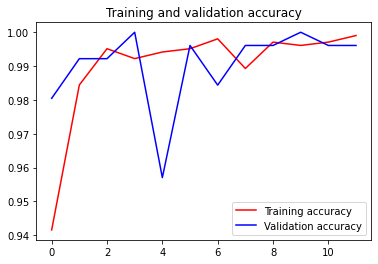

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()